**So the basic overview of this project is to scrape heap lot of data from google news and yahoo finance and then use a deep learning algorithm for summarizing the text and then making sentiment analysis on the summarised text**

# 1.Install and Import Dependencies

**Transformers is a `NLP` library which is a part of huging face and is having a heap lot of functions which are really important and amazing,so we will be importing the `PegasusTokenizer` and the `PegasusModel` itself,this is a state of art deep learning algorithm which means that this a pretrained model,like we had in case of `VGG16/VGG19` similar to that kind and this is trained on text data so we will use this for our `text-summarisation`,more importantly this model works on summarization of financial text data**

In [2]:
import pandas as pd
from transformers import PegasusTokenizer,PegasusForConditionalGeneration
from bs4 import BeautifulSoup
import requests

# 2.Setup Summarization Model

**So as mentioned earlier that we will be using pretrained model for our `financial-text-summarisation`,so we will be using the `financial-summarization-pegasus` model as shown ↓ which is present in the Pegasus Tokenizer and we will install that model and the load it using the ForConditionalGeneration.from_pretained() as shown ↓**

**So in short the tokenizer's main responsibility is to encode and decode the data and the responsibility of the model is to make summarization of the financial text data**

In [3]:
model_name = 'human-centered-summarization/financial-summarization-pegasus'
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

Downloading:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

# 3.Summarize a Single Article

**So here first we will be sending a request to the web using the requests library and the specified url then we will create a `BeautifulSoup` object as shown and then we will scrape all the `paragraphs` from that specified url as shown ↓,so basically if we type in `r.text` we get the response in form of text and the response is `HTML,CSS,JS` as we're requesting for a  webpage on the internet and we are intrested in scraping the `<p>` tags right,so we will specify our parser to be as `htmlparser` which will scrape all the text which is present in the `<p>` tags in the whole webpage!**

In [13]:
## sample run for extracting the data and summarizing a single article

url = 'https://au.news.yahoo.com/woolworths-iga-and-ikea-stores-among-latest-covid-exposure-sites-223840740.html'

r = requests.get(url)

soup = BeautifulSoup(r.text,'html.parser')

paragraphs = []

for paras in soup.find_all('p'):
    paragraphs.append(paras.text)

In [16]:
print(len(paragraphs))
print(paragraphs[:3])

40
["NSW exposure sites ballooned once again overnight as health authorities desperately try to get to grips with Sydney's daunting Covid-19 outbreak.", 'Of particular concern is the Raw Coffee Bar in Belmore in the inner-west where an infectious worker spent 10 days at the premises from July 7 to July 16.', 'Anyone who visited the coffee shop during the listed times must isolate for 14 days and seek testing immediately.\xa0']


In [20]:
## joining all the strings and grabbing only first 400 words
## we chose 400 as a random number as the sumarisation model has a limit
## of how many inputs must be given so for safe side i have used 400

words = ' '.join(paragraphs).split(' ')[:400]
article = ' '.join(words)
article

'NSW exposure sites ballooned once again overnight as health authorities desperately try to get to grips with Sydney\'s daunting Covid-19 outbreak. Of particular concern is the Raw Coffee Bar in Belmore in the inner-west where an infectious worker spent 10 days at the premises from July 7 to July 16. Anyone who visited the coffee shop during the listed times must isolate for 14 days and seek testing immediately.\xa0 Ten new bus route in the city\'s west are listed as close contact exposure routes. There is also a raft of new casual contact exposure sites, including Kmart at Glebe\'s Broadway. Anyone who visited between 3.40pm and 4.25pm on July 8 and 6.45pm and 7pm on the same day must isolate. IGA in Dulwich Hill, Woolworths in Merrylands and Ikea in Marsden Park are also included on the ever-growing list of exposure sites.  More than 100 cases were infectious in the community over the past four days, a statistic causing significant concern to health authorities as they try and dramat

In [21]:
print(len(words),words[:4])

400 ['NSW', 'exposure', 'sites', 'ballooned']


**So here first step is to encode the text,so we will be encoding our text using the tokenizer model which we used earlier,and then we will feed in that encoded input to the model and then decode the result which the model has produced as shown ↓**

In [22]:
input_ids = tokenizer.encode(article,return_tensors='pt')
output = model.generate(input_ids,max_length=55,num_beams=5,early_stopping=True)
summary = tokenizer.decode(output[0],skip_special_tokens=True)

**So the first line which is the encoding phase is taking in input the article and then converting that article into `pytorch tensors` basically is doing encoding which is the basic step in any NLP process,as we can see the result below,on an overview each of the 400 words have been assigned to an `pytorch tensor id` using the `tokenizer.encode()` method as shown ↓**

In [31]:
input_ids[:1][0][:5]

tensor([10871,  3411,  1196, 12120,   316])

**Then once we have generated the input ids,we have to feed that to the model so that it can generate the relavent outputid's which contain the id's of the `summarised` text,then we have to simply pass that to the `tokenizer.decode()`,so this will decode that output_id into the text format and we get the summary of the whole heap of paragraph which consisited of 400 words,so this model internally uses an algorithm named `beamsearch` which will generate a sequence of "meaningful text",early_stopping is used to overcome `overfitting`,so here is output which is a tensors of `id` so we need to decode this so that we can get the output in form of text which is the summary for which we're looking for!**

In [32]:
output

tensor([[    0, 13115,  6288,  2484,   115, 10941,  4378,   117,   790,   177,
          3411,  1196,   107,  1439,   197,  1061,   200, 10251,   115,  4445,
           204,   555,   541,   390,     1]])

In [23]:
summary

'Raw Coffee Bar in Belmore is among new exposure sites. More than 100 people infected in Sydney over past four days'

# 4.Building a News and Sentiment Pipeline

In [33]:
## i will be scrapping stock related data of these GME,Tesla and Bitcoin
## so we will be searching for stock related data of these metioned in list
## from google news and yahoo finance

monitored_tickers = ['GME','TSLA','BTC']

### 4.1.Search for Stock News using Google and Yahoo Finance

**So here we will set up the url as per our needs and make a request to the internet using the requests module,and then use the response which was generated from the requests as a parameter to the beautiful soup and parse out all the a tags from that particular page,and return the scraped href's,best way to do them is by using seleinium tool**

In [65]:
import selenium
from selenium import webdriver
import time
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from collections import defaultdict
import pandas as pd
import numpy as np

In [42]:
options = Options()
options.add_argument("start-maximized")
options.add_argument("--disable-extensions")

options.add_experimental_option("prefs", { \
"profile.default_content_setting_values.media_stream_mic": 1,
"profile.default_content_setting_values.media_stream_camera": 1,
"profile.default_content_setting_values.geolocation": 1,
"profile.default_content_setting_values.notifications": 1
})

# options.add_argument("--incognito")

In [52]:
'''
This code is to scrape href's from the desired webpage
With all the pagination and everything we get the url's
Then we will be looping through each one of those url's and 
scraping the text data {<p>} tags text from each of those pages
and forming summarization of the text!

'''

def searchforstocknews(ticker,findtaglist,paginationlist):
    
    driver = webdriver.Chrome(options=options,
                              executable_path=ChromeDriverManager().install())
    
    searchurl = 'https://www.google.com/search?q=yahoo+finance+'+str(ticker)+'&tbm=nws'
    
    url = driver.get(searchurl)
    hrefs = []
    
    try:
        for clicker in paginationlist:

            try:

                for tag in findtaglist:
                    hrefs.append(driver.find_element_by_xpath(tag).get_attribute('href'))

            except:
                hrefs.append(' ')

            driver.find_element_by_xpath(clicker).click()
            
    except:
        pass

    
    return hrefs

paginationlist = ['//*[@id="xjs"]/table/tbody/tr/td['+str(i)+']/a' for i in range(3,21)]
findtaglist = ['//*[@id="rso"]/div['+str(i)+']/g-card/div/div/div[2]/a' for i in range(1,101)]

'''
Running a loop over all the monitored stocks and scraping the links from the 
search result page using the searchforstocknewsfunction as shown ↓

'''
finalmonitoredlinks = {}
for stock in monitored_tickers:
    finalmonitoredlinks[stock] = searchforstocknews(stock,findtaglist,paginationlist)



====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [C:\Users\meet\.wdm\drivers\chromedriver\win32\91.0.4472.101\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [C:\Users\meet\.wdm\drivers\chromedriver\win32\91.0.4472.101\chromedriver.exe] found in cache


====== WebDriver manager ======
Current google-chrome version is 91.0.4472
Get LATEST driver version for 91.0.4472
Driver [C:\Users\meet\.wdm\drivers\chromedriver\win32\91.0.4472.101\chromedriver.exe] found in cache


In [58]:
for key,links in finalmonitoredlinks.items():
    print(f' Stock {key} has {len(links)} links of data')
    print('-'*50)

 Stock GME has 165 links of data
--------------------------------------------------
 Stock TSLA has 176 links of data
--------------------------------------------------
 Stock BTC has 165 links of data
--------------------------------------------------


##### We will balance out the links as Tesla is having more



In [59]:
finalmonitoredlinks['TSLA'] = finalmonitoredlinks['TSLA'][:165]
for key,links in finalmonitoredlinks.items():
    print(f' Stock {key} has {len(links)} links of data')
    print('-'*50)

 Stock GME has 165 links of data
--------------------------------------------------
 Stock TSLA has 165 links of data
--------------------------------------------------
 Stock BTC has 165 links of data
--------------------------------------------------


In [61]:
finalmonitoredlinks

{'GME': ['https://finance.yahoo.com/news/beyond-gamestop-reddit-wallstreetbets-now-142205449.html',
  'https://finance.yahoo.com/news/gamestop-investors-speculate-meme-stock-203707260.html',
  'https://finance.yahoo.com/news/gamestop-gme-down-13-2-153003874.html',
  'https://finance.yahoo.com/news/you-could-lose-everything-on-meme-stocks-franklin-templeton-ceo-135011534.html',
  'https://finance.yahoo.com/news/i-will-never-cover-game-stop-stock-ever-again-top-analyst-173202488.html',
  'https://finance.yahoo.com/news/why-the-meme-stock-revolution-will-last-093624458.html',
  'https://uk.finance.yahoo.com/news/happening-gamestop-gme-share-price-103815992.html',
  'https://finance.yahoo.com/news/10-reddit-wallstreetbets-meme-stocks-210143666.html',
  'https://finance.yahoo.com/news/meme-stocks-show-that-community-is-profitable-reddit-co-founder-173909883.html',
  'https://finance.yahoo.com/news/forget-amc-gamestop-10-stocks-205845496.html',
  ' ',
  'https://finance.yahoo.com/news/meme-s

### 4.2 Now we need to loop through each url and get the 'p' tags

In [66]:
'''
Try-Excpet is added just to handle out the errors!
Scraping all the text from the webpage and returning as article 

'''
%%time
def gettext(url):
    
    try:
        textdata = []
        response = requests.get(url)
        soup = BeautifulSoup(response.text,'html.parser')
        for para in soup.find_all('p'):
            textdata.append(para.text)

        ## joining all the strings and grabbing only first 400 words
        ## we chose 400 as a random number as the sumarisation model has a limit
        ## of how many inputs must be given so for safe side i have used 400

        words = ' '.join(textdata).split(' ')[:400]
        article = ' '.join(words)
    
    except:
        pass
    
    return article


overalldatamap = defaultdict(list)
for stock,links in finalmonitoredlinks.items():
    overalldata = []
    for link in links:
        if link!=' ':
            overalldatamap[stock].append(gettext(link))
            
    

Wall time: 9min 1s


In [68]:
overalldatamap = dict(overalldatamap)
overalldatamap

{'GME': [" In this article, we discuss the 10 stocks Reddit's WallStreetBets is now targeting. If you want to skip our detailed analysis of these stocks, go directly to Beyond GameStop: Reddit's WallStreetBets is Now Targeting These 5 Stocks. Retail investors have been exercising ever greater influence on the overall market dynamics the past few months, as the record stock rallies of GameStop Corp. (NYSE: GME) and AMC Entertainment Holdings, Inc. (NYSE: AMC) have demonstrated. However, as their influence increases, so does the list of stocks that gain from this influence. The most popular platform where these retail investors exchange ideas is the Reddit forum WallStreetBets. The forum has more than 10.6 million members and is one of the hottest online places in finance.  Some of the stocks presently popular on WallStreetBets include Alibaba Group Holding Limited (NYSE: BABA), Virgin Galactic Holdings, Inc. (NYSE: SPCE), and MicroVision, Inc. (NASDAQ: MVIS). Interestingly, the theory t

In [69]:
for stock,data in overalldatamap.items():
    print(f' Stock {stock} has {len(data)} scraped')
    print('-'*50)

 Stock GME has 150 scraped
--------------------------------------------------
 Stock TSLA has 150 scraped
--------------------------------------------------
 Stock BTC has 150 scraped
--------------------------------------------------


### 4.3 Organising the Data into DataFrame

In [76]:
## as we have scraped text data we need to make sure that 
## there is no duplicacy,so we will be handling that part here as shown 
## removing the duplicates and organising the data into dataframe
## after we have received the clean data we will organise that into
## pandas dataframes,and then we will apply the summarisation logic
## to everytext which we have scraped so far as shown ↓ in the upcoming cells



gme = list(set(overalldatamap['GME']))
tsla = list(set(overalldatamap['TSLA']))
btc = list(set(overalldatamap['BTC']))
df = pd.DataFrame()
df['StockText'] = np.array(gme+tsla+btc)
df['StockOf'] = np.array(['GME']*len(gme)+['TSLA']*len(tsla)+['BTC']*len(btc))
df = df[['StockOf','StockText']]
df

,StockOf,StockText
0,GME,Investors in GameStop Corp. GME need to pay cl...
1,GME,The WallStreetBets bunch has set their sights ...
2,GME,"Reddit investors pack a powerful punch, just a..."
3,GME,In what has simultaneously been one of Wall St...
4,GME,"NEW YORK, NY / ACCESSWIRE / July 16, 2021 / L..."
...,...,...
254,BTC,China is cracking down on Bitcoin. Blockchain....
255,BTC,In 2016 a month’s bitcoin mining with a home c...
256,BTC,Bitcoin (BTC) is trading inside a range betwee...
257,BTC,Bitcoin (BTC) broke down on June 22. falling t...


In [77]:
df.shape

(259, 2)

### 4.4.Summarise all Articles

**The working of this function has been illustrated in the `sample run` which was made in section 2 one can check that out for reference,now as we're having a heap lot of text,we're gonna loop through each text and feed that article as an input to the model so that it can return the summary of that article!,so inorder to make it generalised i will be making a function as shown ↓,so once we get the summarised version we will look whether we're having any empty text or not,or any kind of 'NAN' value,if so we will be ignoring that,as the dataset is quiet low,in general while dealing with large datasets,we cannot ignore that we have to find a way to handle that thing because that may play an important role as such,below is the proposed model arhcitecture which is follwed along the process**

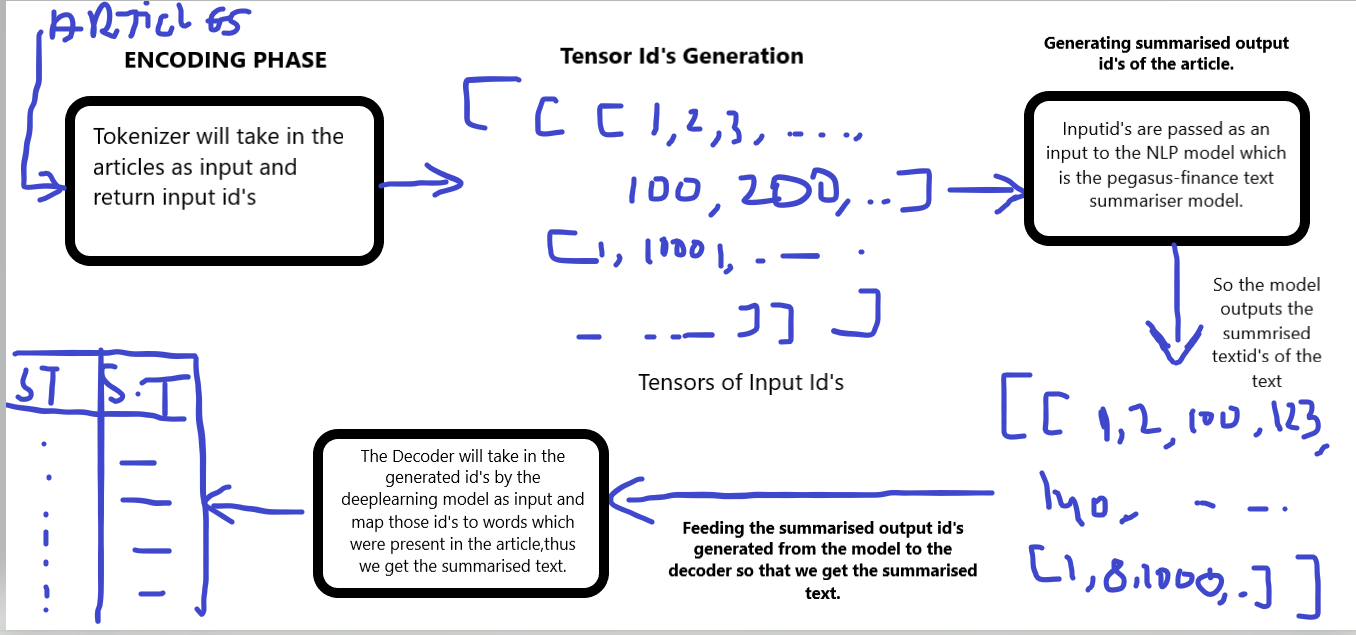

In [82]:
## this function will return summary of that heap long article!
## there will be few cases where you will be encountring index errors
## to avoid them just you can use the try-except mechanism or 
## we can also use some other logic to handle exceptions
## instead of looping all through i have simply applied 
## pandas .apply(lambda x : func(x)) 

%%time

def generatesummary(article):
    
    try:
        input_ids = tokenizer.encode(article,return_tensors='pt')
        output = model.generate(input_ids,max_length=55,num_beams=5,early_stopping=True)
        summary = tokenizer.decode(output[0],skip_special_tokens=True)
        return summary
        
    except:
        pass
    
df['Summary'] = df['StockText'].apply(lambda article:generatesummary(article))

Wall time: 45min 40s


In [83]:
df

,StockOf,StockText,Summary
0,GME,Investors in GameStop Corp. GME need to pay cl...,"Implied volatility is high for the Jul 16, 202..."
1,GME,The WallStreetBets bunch has set their sights ...,Retail investors are piling into meme stocks. ...
2,GME,"Reddit investors pack a powerful punch, just a...",London-based White Square Capital to close dow...
3,GME,In what has simultaneously been one of Wall St...,Geo Group may be Wall Street’s next big meme s...
4,GME,"NEW YORK, NY / ACCESSWIRE / July 16, 2021 / L...",None
...,...,...,...
254,BTC,China is cracking down on Bitcoin. Blockchain....,"Peter Smith, Blockchain.com, says crackdown is..."
255,BTC,In 2016 a month’s bitcoin mining with a home c...,In 2016 a month’s bitcoin mining with a home s...
256,BTC,Bitcoin (BTC) is trading inside a range betwee...,None
257,BTC,Bitcoin (BTC) broke down on June 22. falling t...,None


In [88]:
## looking for BTC stocks

df[df['StockOf']=='BTC'].style.background_gradient(cmap ='plasma')

,StockOf,StockText,Summary
151,BTC,"The crypto market was deeply in the red on Monday, extending a sell-off that began late last week and gathered pace over the weekend. Bitcoin (BTC-USD), the world's biggest cryptocurrency, was down 5.6% to $32,200 (£23,207) by 2.15pm in London. It marked the lowest level for bitcoin in nearly two weeks. Other major tokens were also in the red, with ethereum (ETH-USD) down 7.7% to $1,930 and XRP (XRP-USD) down 8.1% to $0.66. Dogecoin (DOGE-USD), the joke token propelled into the mainstream earlier this year, was down 18.1% to $0.21. By Monday morning, the entire crypto market had lost 6.6% of its value over the last 24 hours, according to data provider CoinMarketCap. The sell-off extends a slump that began late last week after the US Federal Reserve struck an unexpectedly hawkish tilt at its latest policy meeting. The central bank brought forward the timeline for future interest rate hikes, raising the prospect that cheap money may disappearing sooner than expected. The Fed's shift in stance sparked a move away from risk assets and cryptocurrencies have been caught up in the selling. CoinDesk reported that bitcoin fund holdings hit a four month low on Friday in the wake of the Fed meeting. ""Money originates at the Fed then flows through the markets,"" Mati Greenspan, the founder and chief executive of Quantum Economics, told Yahoo Finance UK. ""Now that they're talking about slowing down the pace of new money, or at least signalling that stimulus is not infinite, investors are starting to ask themselves what the true value of these assets are."" Headlines about an ongoing Chinese crackdown on cryptocurrency didn't help sentiment over the weekend. The Block, a cryptocurrency industry website, reported that regulators in Sichuan province had issued a statement ordering crypto miners in the region to shut down. Ruud Feltkamp, chief executive of crypto trading bot Cryptohopper, said: ""People still react strongly to actions from China that create uncertainty, so this is likely to reflect negatively on the Bitcoin price."" Feltkamp and other industry experts said the crackdown would likely have a short-term effect on mining capacity and prices but would likely just drive miners to relocate, rather than exit the industry altogether. ""Worldwide, miners continue to generate on average $30m daily, which shows the industry is still highly profitable,"" said Ulrik K. Lykke, executive director at digital asset fund ARK36. ""It can be reasonably expected that the","Bitcoin tumbles to lowest level in nearly two weeks. Ethereum, Dogecoin hit by regulators in China"
152,BTC,"After another mixed day for the crypto majors on Thursday, it’s been yet another bearish morning for Bitcoin and the broader crypto market. At the time of writing, Bitcoin, BTC to USD, was down by 1.74% to $32,971.0. A mixed start to the day saw Bitcoin rise to an early morning high $33,983.0 before hitting reverse. Falling well short of the first major resistance level at $34,842, Bitcoin slid to a mid-morning intraday low $32,700.0. Steering clear of the first major support level at $32,493, however, Bitcoin found support to revisit $33,000 levels before easing back. Key through the early hours was avoiding the first major support level and a return to sub-$32,000 levels. It’s been a bearish morning for the broader crypto market. At the time of writing, Chainlink was down by 4.51% to lead the way down. Bitcoin Cash SV (-3.40%), Binance Coin (-3.33%), Ethereum (-3.39%), and Litecoin (-3.77%) also struggled. Cardano’s ADA (-2.16%), Crypto.com Coin (-2.58%), Polkadot (-1.55%), and Ripple’s XRP (-2.72%) saw relatively modest losses through the morning, however. Through the early hours, the crypto total market rose to an early morning high $1,380bn before falling to a low $1,325bn. At the time of writing, the total market cap stood at $1,334bn. Bitcoin’s dominance fell to an early low 45.98% before rising to a high 46.44%. At the time of 

# 5.Adding Sentiment Analysis

In [89]:
## seprating the stocks 

gme = df[df['StockOf']=='GME']
tesla = df[df['StockOf']=='TSLA']
btc = df[df['StockOf']=='BTC']

In [90]:
## downloading the sentiment analyser model from transformers

from transformers import pipeline
sentiment = pipeline('sentiment-analysis')
sentiment

Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

In [108]:

%%time

def getsentimentlabels(text):
    
    try:
        sents = sentiment(text)
        labels = sents[0]['label']
        return labels
    
    except:
        pass

def getsentimentscore(text):

    try:    
        sents = sentiment(text)
        score = sents[0]['score']
        return score

    except:
        pass


    

gme = df[df['StockOf']=='GME']
tesla = df[df['StockOf']=='TSLA']
btc = df[df['StockOf']=='BTC']

gme['Label'] = gme['Summary'].apply(lambda text:getsentimentlabels(text))
gme['Score'] = gme['Summary'].apply(lambda text:getsentimentscore(text))

tesla['Label'] = tesla['Summary'].apply(lambda text:getsentimentlabels(text))
tesla['Score'] = tesla['Summary'].apply(lambda text:getsentimentscore(text))


btc['Label'] = btc['Summary'].apply(lambda text:getsentimentlabels(text))
btc['Score'] = btc['Summary'].apply(lambda text:getsentimentscore(text))


C:\Users\meet\anaconda3\envs\tensorflow_ennv\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\meet\anaconda3\envs\tensorflow_ennv\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\meet\anaconda3\envs\tensorflow_ennv\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

Wall time: 12.6 s


C:\Users\meet\anaconda3\envs\tensorflow_ennv\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [109]:
gme

,StockOf,StockText,Summary,Label,Score
0,GME,Investors in GameStop Corp. GME need to pay cl...,"Implied volatility is high for the Jul 16, 202...",NEGATIVE,0.972861
1,GME,The WallStreetBets bunch has set their sights ...,Retail investors are piling into meme stocks. ...,NEGATIVE,0.972520
2,GME,"Reddit investors pack a powerful punch, just a...",London-based White Square Capital to close dow...,NEGATIVE,0.999123
3,GME,In what has simultaneously been one of Wall St...,Geo Group may be Wall Street’s next big meme s...,POSITIVE,0.995260
4,GME,"NEW YORK, NY / ACCESSWIRE / July 16, 2021 / L...",None,None,NaN
5,GME,"In this article, we discuss the 10 stocks Red...",None,None,NaN
6,GME,(Corrects paragraph 5 to say Ryan Cohen is cha...,"Shares in IPO priced at A$17 each, above range...",POSITIVE,0.966807
7,GME,"“Oh people, look around you. The signs are eve...","Fed policy, stimulus checks, wages boosting st...",NEGATIVE,0.993299
8,GME,Not Found Details: cache-del21733-DEL 16265891...,Varnish cache server not found.,NEGATIVE,0.999381
9,GME,"Stocks jumped on Monday, with the three major ...",The Dow Jones Industrial Average had its best ...,NEGATIVE,0.981046


In [110]:
finallist = [gme,tesla,btc]
finaldf = pd.concat(finallist,axis = 0)
finaldf

,StockOf,StockText,Summary,Label,Score
0,GME,Investors in GameStop Corp. GME need to pay cl...,"Implied volatility is high for the Jul 16, 202...",NEGATIVE,0.972861
1,GME,The WallStreetBets bunch has set their sights ...,Retail investors are piling into meme stocks. ...,NEGATIVE,0.972520
2,GME,"Reddit investors pack a powerful punch, just a...",London-based White Square Capital to close dow...,NEGATIVE,0.999123
3,GME,In what has simultaneously been one of Wall St...,Geo Group may be Wall Street’s next big meme s...,POSITIVE,0.995260
4,GME,"NEW YORK, NY / ACCESSWIRE / July 16, 2021 / L...",None,None,NaN
...,...,...,...,...,...
254,BTC,China is cracking down on Bitcoin. Blockchain....,"Peter Smith, Blockchain.com, says crackdown is...",POSITIVE,0.995479
255,BTC,In 2016 a month’s bitcoin mining with a home c...,In 2016 a month’s bitcoin mining with a home s...,NEGATIVE,0.998745
256,BTC,Bitcoin (BTC) is trading inside a range betwee...,None,None,NaN
257,BTC,Bitcoin (BTC) broke down on June 22. falling t...,None,None,NaN


#### Final Touches

In [116]:
finaldf.isnull().sum()

StockOf       0
StockText     0
Summary      69
Label        69
Score        69
dtype: int64

In [119]:
## ignoring the nan 

finaldf = finaldf.dropna()
finaldf.isnull().sum()

StockOf      0
StockText    0
Summary      0
Label        0
Score        0
dtype: int64

In [120]:
finaldf

,StockOf,StockText,Summary,Label,Score
0,GME,Investors in GameStop Corp. GME need to pay cl...,"Implied volatility is high for the Jul 16, 202...",NEGATIVE,0.972861
1,GME,The WallStreetBets bunch has set their sights ...,Retail investors are piling into meme stocks. ...,NEGATIVE,0.972520
2,GME,"Reddit investors pack a powerful punch, just a...",London-based White Square Capital to close dow...,NEGATIVE,0.999123
3,GME,In what has simultaneously been one of Wall St...,Geo Group may be Wall Street’s next big meme s...,POSITIVE,0.995260
6,GME,(Corrects paragraph 5 to say Ryan Cohen is cha...,"Shares in IPO priced at A$17 each, above range...",POSITIVE,0.966807
...,...,...,...,...,...
251,BTC,"BeinCrypto spoke to Alexander Höptner, CEO of ...",Hptner says he will use bitcoin in everyday li...,POSITIVE,0.982410
252,BTC,Bitcoin’s (BTC) price gave up some of its gain...,"Initial resistance seen around $36,000. Bitcoi...",NEGATIVE,0.999617
253,BTC,"As bitcoin nears support at $30,000, analysts ...","Delta Exchange sees a bounce to $40,000 in com...",NEGATIVE,0.998385
254,BTC,China is cracking down on Bitcoin. Blockchain....,"Peter Smith, Blockchain.com, says crackdown is...",POSITIVE,0.995479


## Where can we use this


**Basically we can run the script and get the summary of all the stock news which is going as of today with a sentiment of whether that data is positive or negative as we can observe this in the dataframe,and get to know heap lot of information regarding this!**

# 6.Exporting Results

In [121]:
finaldf.to_csv('finalsummaryreport.csv',index=None)